## Boston bike rides duration prediction

### Import necessary libraries

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

### Load the datasets

In [82]:
# Please replace the path variable by the directory where the files will be stored.

path= 'C:\\Users\\krasi\\pyproj\\datasets\\Technical test 2023\\data\\'

weather_data= pd.read_csv(path + 'weather.csv')
hubway_trips= pd.read_csv(path + 'hubway_trips.csv')
hubway_stations= pd.read_csv(path + 'hubway_stations.csv')

In [83]:
weather_data.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,


In [84]:
hubway_trips.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [85]:
hubway_stations.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


### Data Cleaning

In [86]:
# Change the dates column into the datetime type, 
# this would allow us to merge weather and hubway trips tables based on date columns.

hubway_trips['start_date']= pd.to_datetime(hubway_trips['start_date'])
hubway_trips['end_date']= pd.to_datetime(hubway_trips['end_date'])
weather_data['DATE']= pd.to_datetime(weather_data['DATE'])

In [87]:
# Change the dates into the Hours period to allow merging the weather data into. 
# Additionally we need to subtract one hour from the weather DATE, because based on the documentation 
# this value at certain hour is accumulation from hour before - for example if we have a measurement 
# at time 10 pm it means this is the accumulation measure from 9 pm to 10 pm.

from datetime import timedelta

hubway_trips['DATE']= hubway_trips.start_date.dt.to_period("H")
weather_data['DATE']= weather_data.DATE.dt.to_period("H") - timedelta(hours=1)

# Merge the hubway trips and weather data together 
data= hubway_trips.merge(weather_data, how="left", on="DATE")

In [88]:
# Merge data table with hubway stations information, we will do this 2 times, both for
# staring station as well as end station

data= data.merge(hubway_stations, how="left", left_on="strt_statn", right_on="id")
data= data.merge(hubway_stations, how="left", left_on="end_statn", right_on="id")

data_copy=data

In [89]:
# We can drop columns with one unique value,
# these columns does not contain any information as the variance is 0 so we can drop them
# - they have no predictive power.

print(data.nunique())

#Drop the columns with one unique value

one_value_columns= data.columns[data.nunique()==1]
data.drop(one_value_columns, axis=1, inplace=True)

seq_id              1579025
hubway_id           1579025
status_x                  1
duration              15635
start_date           521432
strt_statn              142
end_date             515102
end_statn               142
bike_nr                1163
subsc_type                2
zip_code                530
birth_date               60
gender                    2
DATE                  14713
STATION                   1
STATION_NAME              1
ELEVATION                 1
LATITUDE                  1
LONGITUDE                 1
HPCP                     50
Measurement_Flag          3
Quality_Flag              1
id_x                    142
terminal_x              131
station_x               137
municipal_x               4
lat_x                   142
lng_x                   142
status_y                  2
id_y                    142
terminal_y              131
station_y               137
municipal_y               4
lat_y                   142
lng_y                   142
status              

In [90]:
data.sample(2)

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,...,lat_x,lng_x,status_y,id_y,terminal_y,station_y,municipal_y,lat_y,lng_y,status
626027,626028,707489,360,2012-10-31 17:44:00,22.0,2012-10-31 17:50:00,31.0,T01342,Registered,'02210,...,42.352175,-71.055547,Existing,31.0,B32014,Seaport Hotel,Boston,42.348833,-71.041747,Existing
222273,222274,254593,651,2012-05-17 08:06:00,38.0,2012-05-17 08:17:00,42.0,B00386,Registered,'01867,...,42.366231,-71.060868,Removed,42.0,D32007,Boylston St. at Arlington St.,Boston,42.352096,-71.070378,Existing


In [91]:
data.columns

Index(['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'DATE', 'HPCP', 'Measurement_Flag', 'id_x',
       'terminal_x', 'station_x', 'municipal_x', 'lat_x', 'lng_x', 'status_y',
       'id_y', 'terminal_y', 'station_y', 'municipal_y', 'lat_y', 'lng_y',
       'status'],
      dtype='object')

In [92]:
# Rename _x and _y columns for _start and _end respectively

data.columns = ['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'DATE', 'HPCP', 'Measurement_Flag', 'id_start',
       'terminal_start', 'station_start', 'municipal_start', 'lat_start', 'lng_start', 'status_start',
       'id_end', 'terminal_end', 'station_end', 'municipal_end', 'lat_end', 'lng_end',
       'status_end']

## Start Date features extract

In [93]:
# I will extract month, day of week, hour as this time features can have an impact on the duration

data['month']= data['start_date'].dt.month
data['day_of_week']= data['start_date'].dt.dayofweek
data['hour']= data['start_date'].dt.hour
data['weekend']= np.nan
data.loc[data['day_of_week']<=4,'weekend'] = 0
data.loc[data['day_of_week']>4,'weekend'] = 1
data['weekend']=data['weekend'].astype(int)

In [94]:
# We will drop rows with stations that were removed 
# as we can't take them into consideration predicting the duration, as they don't exist

data.drop(data[data.status_end=="Removed"].index, axis=0, inplace=True)
data.drop(data[data.status_start=="Removed"].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [95]:
# We will extract first letter from the terminal start-
# we will see if it contain some predicting power after

data['terminal_letter_start'] = data['terminal_start'].apply(lambda x: str(x)[0])

In [96]:
data.terminal_letter_start.value_counts()

D    428369
M    294062
B    293281
A    184339
C    175715
S     39581
K     19944
E      1793
n        12
Name: terminal_letter_start, dtype: int64

In [97]:
# Now as we have all the data merged together we can start to clean up the data.
# We can get rid of some duplicate columns and unique id columns, these will 
# be not good predictive features

data.drop(['seq_id', 'hubway_id', 'id_start', 'id_end', 'zip_code', 'end_date',
           'station_start', 'station_end', 'municipal_end', 'municipal_start', 'status_start',
          'status_end'],axis=1, inplace=True)

In [98]:
data.iloc[:5,:15]

,duration,start_date,strt_statn,end_statn,bike_nr,subsc_type,birth_date,gender,DATE,HPCP,Measurement_Flag,terminal_start,lat_start,lng_start,terminal_end
0,1108,2011-07-28 11:55:00,47.0,40.0,B00550,Registered,1994.0,Male,2011-07-28 11:00,NaN,NaN,D32010,42.362811,-71.056067,D32006
1,1055,2011-07-28 11:55:00,47.0,40.0,B00580,Registered,1956.0,Male,2011-07-28 11:00,NaN,NaN,D32010,42.362811,-71.056067,D32006
2,1042,2011-07-28 11:55:00,47.0,40.0,B00539,Registered,1959.0,Female,2011-07-28 11:00,NaN,NaN,D32010,42.362811,-71.056067,D32006
3,994,2011-07-28 12:00:00,40.0,47.0,B00368,Casual,NaN,NaN,2011-07-28 12:00,NaN,NaN,D32006,42.363871,-71.050877,D32010
4,15,2011-07-28 12:00:00,22.0,22.0,B00442,Registered,1982.0,Male,2011-07-28 12:00,NaN,NaN,A32010,42.352175,-71.055547,A32010


In [99]:
data.iloc[:5,15:]

,lat_end,lng_end,month,day_of_week,hour,weekend,terminal_letter_start
0,42.363871,-71.050877,7,3,11,0,D
1,42.363871,-71.050877,7,3,11,0,D
2,42.363871,-71.050877,7,3,11,0,D
3,42.362811,-71.056067,7,3,12,0,D
4,42.352175,-71.055547,7,3,12,0,A


#### Checking missing values

In [100]:
data.isna().sum()

duration                       0
start_date                     0
strt_statn                    12
end_statn                     42
bike_nr                      358
subsc_type                     0
birth_date               1181038
gender                    427609
DATE                           0
HPCP                     1354550
Measurement_Flag         1354550
terminal_start                12
lat_start                     12
lng_start                     12
terminal_end                  42
lat_end                       42
lng_end                       42
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
dtype: int64

#### We see in the above that there are couple missing values in some columns, we can drop the rows where they are missing, it will not impact the model performance as these rows are very small subset of our data, we will drop the rows where status_end, status_start or bike_nr is NA value.

In [101]:
data.dropna(axis=0, subset=['strt_statn', 'end_statn', 'bike_nr'], inplace=True)

In [102]:
# We are left with four columns to clean up 

data.isna().sum()

duration                       0
start_date                     0
strt_statn                     0
end_statn                      0
bike_nr                        0
subsc_type                     0
birth_date               1180815
gender                    427390
DATE                           0
HPCP                     1354175
Measurement_Flag         1354175
terminal_start                 0
lat_start                      0
lng_start                      0
terminal_end                   0
lat_end                        0
lng_end                        0
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
dtype: int64

In [103]:
# For the HPCP  we will fill 0 in the precipitation measure as based on documentation 
# hours with no precipitation are not shown.

data['HPCP']= data['HPCP'].fillna(0)

In [104]:
# Let's check how many unique values we have in the measurement flag column

data.Measurement_Flag.value_counts()

T    49958
     32313
g      246
Name: Measurement_Flag, dtype: int64

In [105]:
# We will create another column 'Rain' 
# from the HPCP column to indcate whether it was raining or not during the bike trip

data['Rain'] = data['HPCP'].apply(lambda x: x>0).astype(int)

# T value is indicating trace precipitation less than 0.01. We will feed Rain column with that info
# assigning value 1 wherever there is a T flag in a row.

data.loc[data.Measurement_Flag=='T', 'Rain'] = 1

In [106]:
# Now we can drop the column Measurement flag as info about that is in the HPCP column.

data.drop(['Measurement_Flag'], axis=1, inplace=True)

In [107]:
#For gender column we will fill NA values by "Unknown" string, I don't want to drop this column as 
# it can be a good predictor

data['gender']= data['gender'].fillna("Unknown")

In [108]:
data.isna().sum()

duration                       0
start_date                     0
strt_statn                     0
end_statn                      0
bike_nr                        0
subsc_type                     0
birth_date               1180815
gender                         0
DATE                           0
HPCP                           0
terminal_start                 0
lat_start                      0
lng_start                      0
terminal_end                   0
lat_end                        0
lng_end                        0
month                          0
day_of_week                    0
hour                           0
weekend                        0
terminal_letter_start          0
Rain                           0
dtype: int64

In [109]:
# We will create age feature from birth_date

data['year']= data['start_date'].dt.year.astype(int)
data['age']= data['year'] - data['birth_date']
data[['year', 'birth_date', 'age']]

,year,birth_date,age
0,2011,1994.0,17.0
1,2011,1956.0,55.0
2,2011,1959.0,52.0
3,2011,NaN,NaN
4,2011,1982.0,29.0
...,...,...,...
1437091,2013,NaN,NaN
1437092,2013,NaN,NaN
1437093,2013,NaN,NaN
1437094,2013,NaN,NaN


<Axes: xlabel='age', ylabel='duration'>

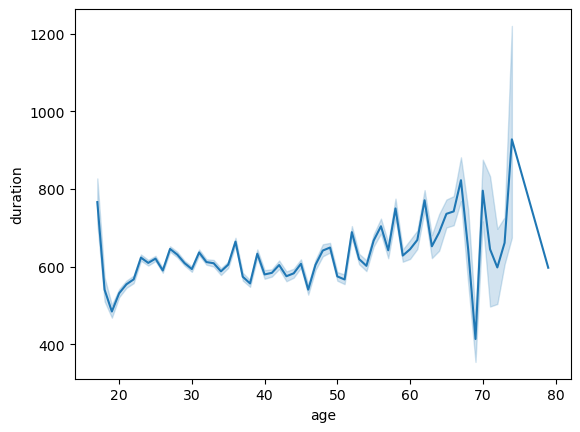

In [110]:
sns.lineplot(data=data[data.duration<2500], x='age', y='duration')

In [111]:
# We will create age category feature 
data['age_cat']= pd.cut(data.age, 6)


In [112]:
# Replacing NAN values in age_cat feature by new category 'Unknown'

data['age_cat'].cat.add_categories(['Unknown'], inplace=True)
data.loc[data.age_cat.isna() ,'age_cat']= 'Unknown'

C:\Users\krasi\AppData\Local\Temp\ipykernel_2672\3465042091.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  data['age_cat'].cat.add_categories(['Unknown'], inplace=True)


In [113]:
data.age_cat.value_counts()

Unknown             1180815
(27.333, 37.667]      95183
(16.938, 27.333]      76406
(37.667, 48.0]        48705
(48.0, 58.333]        27399
(58.333, 68.667]       7794
(68.667, 79.0]          390
Name: age_cat, dtype: int64

In [114]:
# We create a feature that will derive the first letter from the Bike number, 
# we will then see what predictive power it will have

data['bike_id']= data.bike_nr.apply(lambda x: str(x)[0])

In [115]:
# We will create another column to check if person is subscribed or not

def registered(x):
    if x=='Registered':
        return 1
    else:
        return 0

data['subscription'] = data['subsc_type'].apply(registered)

In [143]:
# Change below two columns into categorical type
cat_cols=['strt_statn','terminal_letter_start','month', 'hour', 'day_of_week']

for col in cat_cols:
    pd.Categorical(data[col])

KeyError: 'day_of_week'

In [150]:
data['terminal_letter_start']= data['terminal_letter_start'].astype('category')

In [117]:
# We can drop columns that we don't need anymore

data.drop(['bike_nr', 'subsc_type', 'lat_start',
           'lng_start', 'lat_end', 'lng_end', 'terminal_end', 'end_statn',
           'terminal_start', 'HPCP', 'year', 'age', 'birth_date', 'start_date', 'DATE'], axis=1, inplace=True)

In [118]:
data.sample(5)

,duration,strt_statn,gender,month,day_of_week,hour,weekend,terminal_letter_start,Rain,age_cat,bike_id,subscription
795910,720,89.0,Male,6,4,20,0,M,0,Unknown,B,1
434381,480,9.0,Female,10,2,17,0,A,1,Unknown,B,1
1402047,120,21.0,Male,11,1,16,0,C,0,Unknown,B,1
1003422,480,63.0,Male,8,3,8,0,C,0,Unknown,T,1
387740,413,27.0,Female,9,3,8,0,C,0,"(27.333, 37.667]",T,1


In [173]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['age_cat'] = le.fit_transform(data['age_cat'])
data['terminal_letter_start'] = le.fit_transform(data['terminal_letter_start'])

## Exploratory Data Analysis

In [119]:
# Check the target skewness

print(data.duration.median())
print(data.duration.mean())

# Lets get rid of outliers from the duration column that have duration more than 2500.
# Also there are some rows where duration are below zero, we will drop those rows as well

data.drop(data[(data.duration>2500) | (data.duration<0)].index, axis=0, inplace=True)

660.0
1126.4060174344954


<Axes: xlabel='duration', ylabel='Density'>

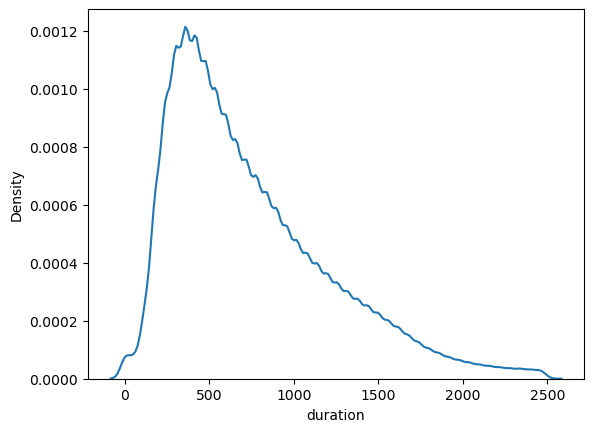

In [120]:
# We see below that the data is skewed but less than before.

sns.kdeplot(data=data, x='duration')

<Axes: xlabel='age_cat', ylabel='duration'>

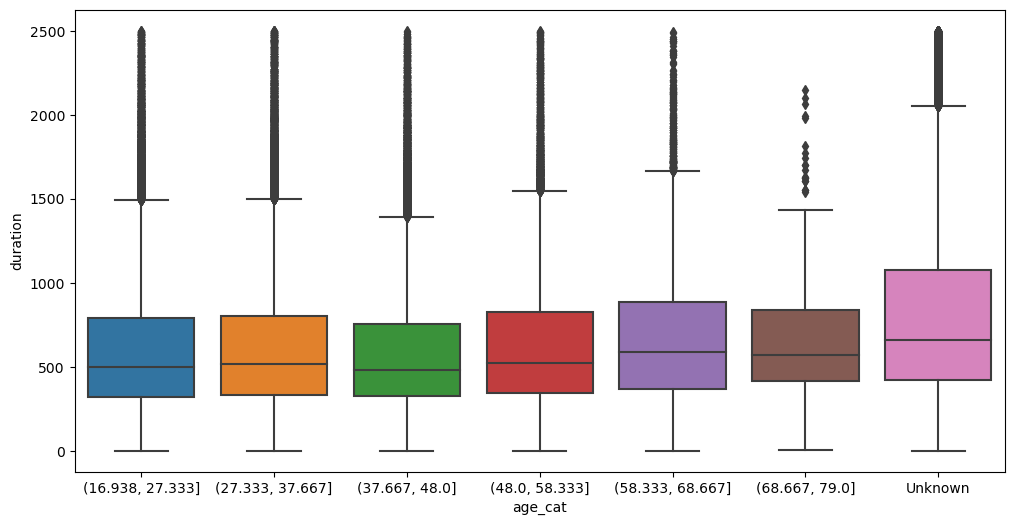

In [121]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=data, x='age_cat', y='duration')

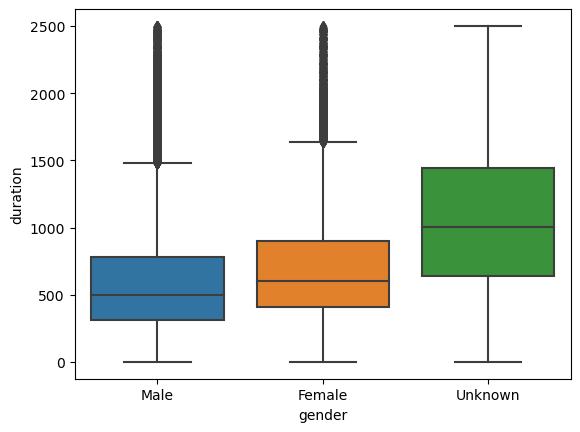

In [122]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='gender', y='duration', data=data)

data= pd.get_dummies(data, columns=['gender'], drop_first=True)

<Axes: xlabel='month', ylabel='duration'>

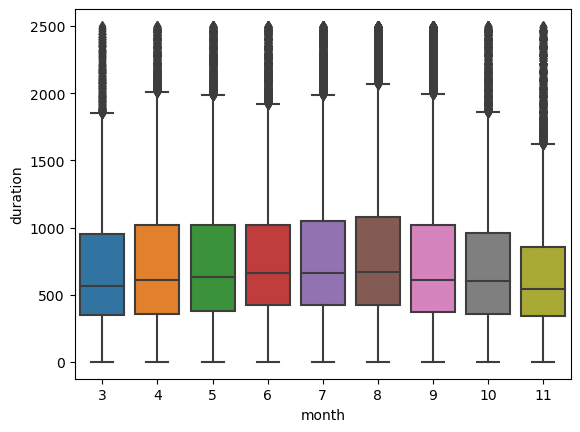

In [123]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='month', y='duration', data=data)

<Axes: xlabel='weekend', ylabel='duration'>

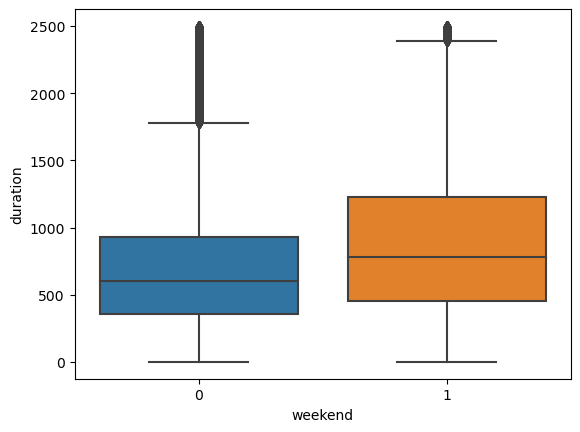

In [124]:
# Lets see the predictive power of our features - 
# the gender column seems to have an impact on the duration, let's create two hot one columns from the gender

sns.boxplot(x='weekend', y='duration', data=data)

<Axes: xlabel='hour', ylabel='duration'>

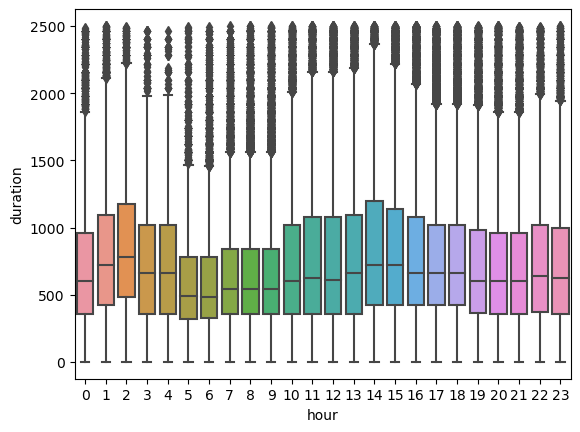

In [125]:
sns.boxplot(x='hour', y='duration',data=data)

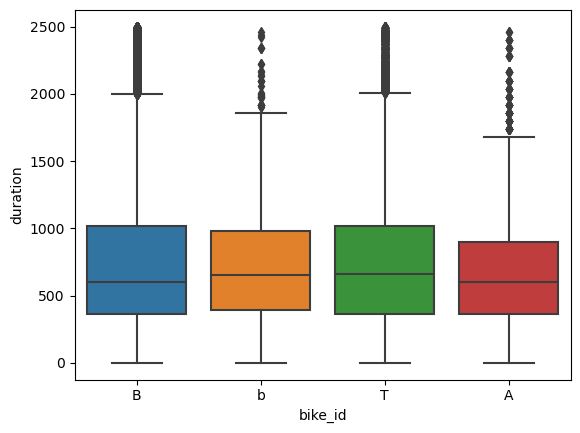

In [126]:
# We can drop bike_id as all groups have proportional means and variances in the durations outcome. 
sns.boxplot(x='bike_id', y='duration', data=data)

data.drop('bike_id', axis=1, inplace=True)

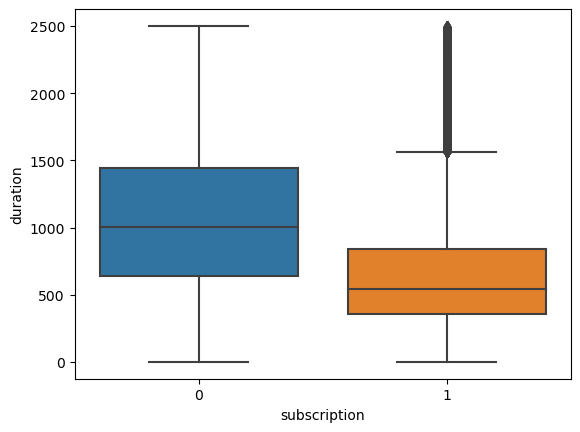

In [127]:
# The subscription feature is good predictor of 
# duration as we see that the two groups differs signifcantly from each other

sns.boxplot(x='subscription', y='duration', data=data)

# Nevertheless we will drop the subscription column because the info about subscription is in the gender column
# already - every person that is subscribed is labeled either Male or female in Gender, all the Unknown record are also
# unsubscribed.

data.drop('subscription',axis=1, inplace=True)

<Axes: xlabel='Rain', ylabel='duration'>

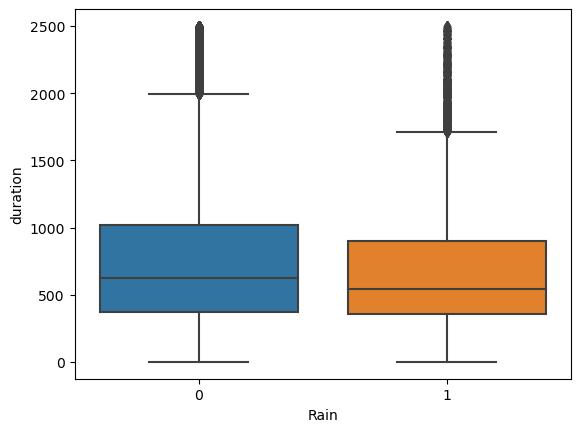

In [128]:
# It does not seem that rain is a factor in predicting the duration of a trip

sns.boxplot(data=data, x='Rain',  y='duration')

<Axes: xlabel='terminal_letter_start', ylabel='duration'>

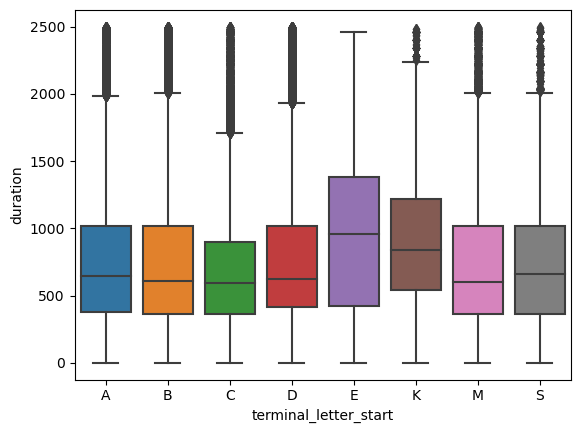

In [152]:
sns.boxplot(data=data, x='terminal_letter_start', y='duration')

<Axes: >

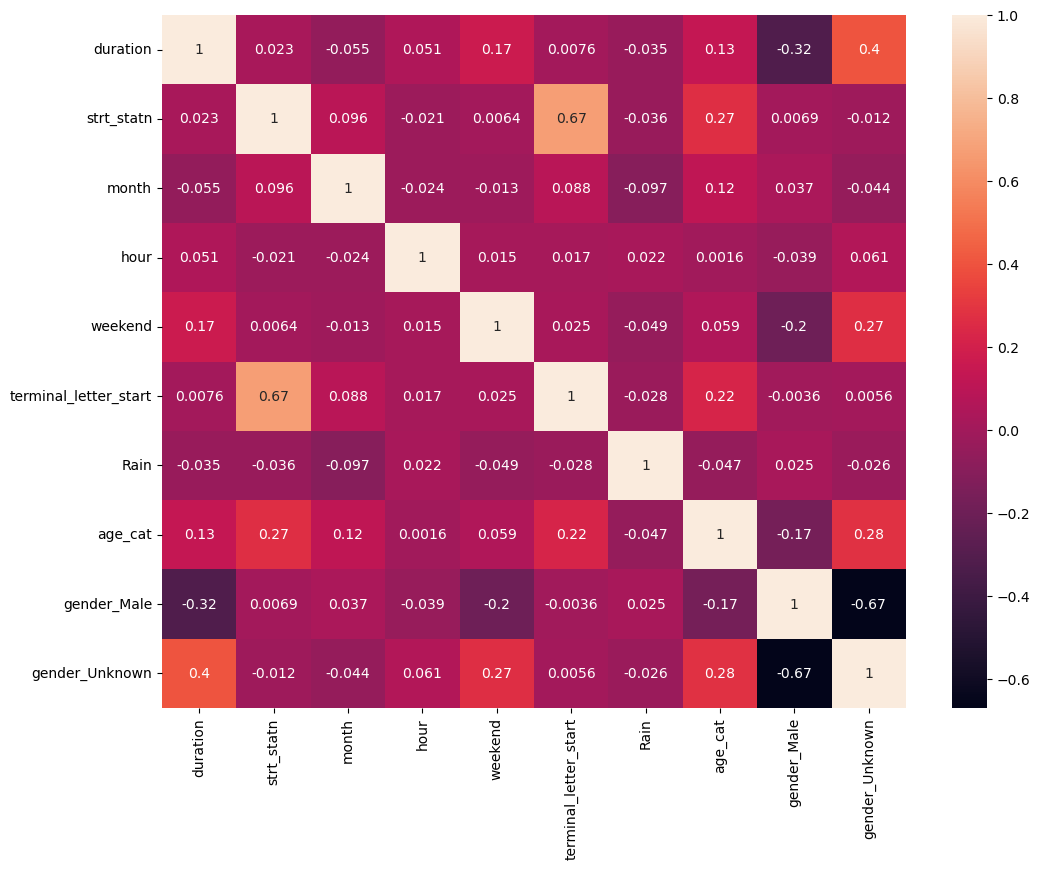

In [177]:
# We can also look at correlation matrix to check which features are highly correlated with duration

corr= data.corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=True)

In [130]:
# Lastly we will drop day_of_week column as it is highly correlated with another feature weekend column

data.drop('day_of_week', axis=1, inplace=True)

In [172]:
data.head()

,duration,strt_statn,month,hour,weekend,terminal_letter_start,Rain,age_cat,gender_Male,gender_Unknown
0,1108,47.0,7,11,0,D,0,0,1,0
1,1055,47.0,7,11,0,D,0,3,1,0
2,1042,47.0,7,11,0,D,0,3,0,0
3,994,40.0,7,12,0,D,0,6,0,1
4,15,22.0,7,12,0,A,0,1,1,0


## Model training

### I'll chose Random Forest Regressor as my model, the decision trees are providing better results when trained on skewed target and predictors than other models

In [178]:
#Lets see shape of our dataset

data.shape

(1365709, 10)

In [179]:
# We need to limit the data we use in the model training - we don't have too many features in the model so random sample
# of 20% of the data will improve how fast the model will be trained and evaluated

model_data= data.sample(frac=0.2, random_state=11112).reset_index(drop=True)
model_data

,duration,strt_statn,month,hour,weekend,terminal_letter_start,Rain,age_cat,gender_Male,gender_Unknown
0,840,44.0,9,21,0,3,0,6,1,0
1,1920,36.0,5,13,1,3,0,6,0,1
2,840,58.0,8,15,1,3,0,6,1,0
3,900,112.0,10,17,1,3,0,6,1,0
4,240,27.0,10,7,0,2,0,6,1,0
...,...,...,...,...,...,...,...,...,...,...
273137,1080,22.0,7,14,1,0,0,6,1,0
273138,900,32.0,11,11,1,1,0,6,0,1
273139,780,126.0,5,2,0,5,0,6,0,0
273140,1140,45.0,8,21,0,1,0,6,1,0


In [180]:
# Import Random Forest regressor
from sklearn.ensemble import RandomForestRegressor

# Set target and predictors

X= model_data.drop('duration', axis=1)
Y= model_data['duration']

In [181]:
# Split data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=11)

In [186]:
# I will use the RandomizedSearchCV to pick the best parameters for the model
# As we have many parameters we will set n_iter=10 to pick randomly 10 different sets of parameters.

from sklearn.model_selection import RandomizedSearchCV

model = RandomForestRegressor()

rs = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {'max_depth': [100, 200, 400],
                                               'min_samples_split':  [10, 20, 50, 100],
                                               'n_estimators': [50, 100, 200] },
                        cv=5, n_jobs=-1, random_state=31,
                        scoring='neg_mean_squared_error')


# Fit the Randomized Search to X_train, y_train
rs.fit(X_train, y_train)

# Print the best parameters and mean_squared_error for them

print(rs.best_params_)
print(-rs.best_score_)

{'n_estimators': 100, 'min_samples_split': 100, 'max_depth': 200}
173934.36433218262


In [187]:
173934**(0.5)

417.05395334416863

### It may take some time for RandomizedSearchCV to run. After we will find the best parameters for our model we can train the Random Forest Regressor model with these parameters

# The END